In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from joblib import Parallel, delayed

__AUTHOR__ = 'Kirgsn'

class Reducer:
    """
    Class that takes a dict of increasingly big numpy datatypes to transform
    the data of a pandas dataframe to in order to save memory usage.
    """
    memory_scale_factor = 1024**2  # memory in MB

    def __init__(self, conv_table=None):
        """
        :param conv_table: dict with np.dtypes-strings as keys
        """
        if conv_table is None:
            self.conversion_table = \
                {'int': [np.int8, np.int16, np.int32, np.int64],
                 'uint': [np.uint8, np.uint16, np.uint32, np.uint64],
                 'float': [np.float16, np.float32, ]}
        else:
            self.conversion_table = conv_table

    def _type_candidates(self, k):
        for c in self.conversion_table[k]:
            i = np.iinfo(c) if 'int' in k else np.finfo(c)
            yield c, i

    def reduce(self, df, verbose=False):
        """Takes a dataframe and returns it with all data transformed to the
        smallest necessary types.

        :param df: pandas dataframe
        :param verbose: If True, outputs more information
        :return: pandas dataframe with reduced data types
        """
        ret_list = Parallel(n_jobs=-1)(delayed(self._reduce)
                                                (df[c], c, verbose) for c in
                                                df.columns)

        return pd.concat(ret_list, axis=1)

    def _reduce(self, s, colname, verbose):

        # skip NaNs
        if s.isnull().any():
            if verbose:
                print(colname, 'has NaNs - Skip..')
            return s

        # detect kind of type
        coltype = s.dtype
        if np.issubdtype(coltype, np.integer):
            conv_key = 'int' if s.min() < 0 else 'uint'
        elif np.issubdtype(coltype, np.floating):
            conv_key = 'float'
        else:
            if verbose:
                print(colname, 'is', coltype, '- Skip..')
            print(colname, 'is', coltype, '- Skip..')
            return s

        # find right candidate
        for cand, cand_info in self._type_candidates(conv_key):
            if s.max() <= cand_info.max and s.min() >= cand_info.min:

                if verbose:
                    print('convert', colname, 'to', str(cand))
                return s.astype(cand)

        # reaching this code is bad. Probably there are inf, or other high numbs
        print(("WARNING: {} " 
               "doesn't fit the grid with \nmax: {} "
               "and \nmin: {}").format(colname, s.max(), s.min()))
        print('Dropping it..')
        

df = pd.read_csv("train.csv")

reducer = Reducer()
df = reducer.reduce(df)

def display_all_rows(data, num=None):
    pd.set_option('display.max_rows', num)
    display(data)
    pd.set_option('display.max_rows', 100)

def display_visitor(data, No):
    criteria = data['VisitNumber'] == No
    display(data[criteria])
    
def display_all_columns(data):
    pd.set_option('display.max_columns', None)
    display(data)
    pd.set_option('display.max_columns', 100)

수정님

In [4]:
def float_to_str(obj):
    """
    Convert Upc code from float to string
    Use this function by applying lambda
    :param obj: "Upc" column of DataFrame
    :return: string converted Upc removing dot.
    """
    while obj != "nan":
        obj = str(obj).split(".")[0]
        return obj


def company(x):
    """
    Return company code from given Upc code.
    :param x: "Upc" column of DataFrame
    :return: company code
    """
    try:
        p = x[:6]
        if p == "000000":
            return x[-5]
        return p
    except:
        return -9999

train["Upc"] = train.Upc.apply(float_to_str)
# test["Upc"] = test.Upc.apply(float_to_str)

train["company"] = train.Ubpc.apply(company) 
# test["company"] = test.Upc.apply(company)

train_com = train.loc[:, ['VisitNumber', 'company']].drop_duplicates()
train_com['val'] = True
train_com.pivot('VisitNumber', 'company', 'val')

1차 가공

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Fill Na
# Dept Na -> Upc: 0.1, Dept: Na. FN: 0.1
c = df['DepartmentDescription'].isnull()
df[c] = df[c].fillna({'Upc': 0.1, 'DepartmentDescription': 'Na', 'FinelineNumber': 0.1})

# 아래 코드
df_d_sum = df.groupby(['VisitNumber', 'DepartmentDescription'], as_index=False)['ScanCount'].agg('sum').sort_values(['VisitNumber', 'ScanCount', 'DepartmentDescription'], ascending=[1, 0, 1])
df_d_sum['abs_sum'] = df_d_sum.assign(abs=df_d_sum['ScanCount'].abs()).groupby(['VisitNumber'])['abs'].transform('sum')

# change 'abs_sum' for div
criteria = df_d_sum['abs_sum'] == 0
df_d_sum.loc[criteria, 'abs_sum'] = 999

# create ratio
df_d_sum['ratio'] = df_d_sum['ScanCount'] / df_d_sum['abs_sum']

# abs_sum 원복
criteria = df_d_sum['abs_sum'] == 999
df_d_sum.loc[criteria, 'abs_sum'] = 0

# Dept Na 였던 VisitNumber append
diff = set(df.VisitNumber) - set(df_d_sum.VisitNumber)
df_d_sum = df_d_sum.append(pd.DataFrame({'VisitNumber': list(diff)},)).fillna({'DepartmentDescription': 'Na',
                                                                         'ScanCount': 0,
                                                                         'ratio':0 })
# create pivot table
df_pivot = df_d_sum.pivot(index='VisitNumber', columns='DepartmentDescription', values='ratio').fillna(0)
df_pivot = pd.merge(df_pivot, df[['VisitNumber', 'TripType']].drop_duplicates(), on='VisitNumber')

# create TT vs ratio
df_ratio = pd.merge(df_d_sum, df[['VisitNumber', 'TripType']].drop_duplicates(), on='VisitNumber')
df_ratio = df_ratio.sort_values(['TripType', 'VisitNumber', 'ratio'], ascending=[1, 1, 0]).iloc[:, [2, 5, 0, 4]].set_index(['VisitNumber', 'TripType'])

df_check_ratio = df_ratio.set_index('DepartmentDescription', append=True).sum(level=[1,2]).rename(columns={'ratio':'ratio_sum'})
df_check_ratio = df_check_ratio.sort_values(['TripType', 'ratio_sum'], ascending=[1, 0])

# Dept ratio within TripType
df_check_ratio['TT_Dept_ratio'] = df_check_ratio/df_check_ratio.sum(level=0)

# make training data
# X = df_pivot.iloc[:, :-1]
# y = df_pivot.iloc[:, -1]

# X_t, X_te, y_t, y_te = train_test_split(X, y, test_size = 0.3, random_state=99)

# # training

# # mod2 = RandomForestClassifier(n_estimators=200, bootstrap=False, min_samples_leaf=1, min_samples_split=3,\
# #                              criterion='gini').fit(X_t, y_t)

# # print(classification_report(y_te, mod2.predict(X_te)))



2차 가공

In [3]:
# top5 Dept
top5_Dept = list(df_check_ratio.groupby('TripType').head(5).reset_index()['DepartmentDescription'].drop_duplicates())

# diff(VisitNumber of ~isin Dept )
c = df_ratio['DepartmentDescription'].isin(top5_Dept)
diff = set(df['VisitNumber'].unique()) - set(df_ratio[c].reset_index()['VisitNumber'].unique())
df_ratio_top5 = df_ratio[c]

# dept top5
df_train = df_ratio_top5.reset_index().pivot(index='VisitNumber',\
                                  columns='DepartmentDescription',\
                                 values='ratio').append(pd.DataFrame(index=diff))

# New_col isZero&Negative
temp1 = df_d_sum.iloc[:, [2,1]].set_index('VisitNumber').sum(level=0)
temp1['isZeroNegative'] = False
c = temp1['ScanCount'] <= 0
temp1.loc[c, 'isZeroNegative'] = True
temp1 = temp1.iloc[:, [1]]

# New_col boolean dept:
c2 = df_d_sum.reset_index()['VisitNumber'].isin(diff)

boolean_dept = list(df_ratio.reset_index().loc[c2, 'DepartmentDescription'].unique())

c = df_d_sum.reset_index()['DepartmentDescription'].isin(boolean_dept)
df_sub = df_d_sum.reset_index()[c&c2].iloc[:, [3, 1]]
df_sub.loc[:, 'val'] = True
df_sub.loc[:, 'DepartmentDescription'] = df_sub['DepartmentDescription'].apply(lambda x: str(x) + '_boolean') 
df_sub = df_sub.pivot('VisitNumber', 'DepartmentDescription', 'val').fillna(False)

# Dept top5 + boolean
temp = pd.DataFrame(data=False, columns=df_sub.columns, index=df_train.index).\
 rename({'DepartmentDescription':'VisitNumber'}, axis='index')
df_train = pd.concat([df_train, temp], axis=1)

# + New_col
df_train = pd.concat([df_train, temp1], axis=1)

# + TripType
temp = df.loc[:, ['VisitNumber','TripType']].drop_duplicates('VisitNumber').set_index('VisitNumber')
df_train = pd.concat([df_train, temp], axis=1)

test2

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

y = df_train.iloc[:, -1]
x = df_train.drop('TripType', axis=1).fillna(0)

le = LabelEncoder()
y_labeled = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(x, y_labeled, random_state=0)

rdf = RandomForestClassifier(n_estimators=330, bootstrap=True, min_samples_split=2,\
                             criterion='gini', n_jobs=3).fit(pd.get_dummies(X_train), y_train)


In [9]:
print(classification_report(y_test, rdf.predict(pd.get_dummies(X_test))))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87       931
           1       0.25      0.01      0.02        87
           2       0.75      0.84      0.79      1167
           3       0.66      0.75      0.70       309
           4       0.66      0.66      0.66      1494
           5       0.68      0.82      0.75      3017
           6       0.60      0.76      0.67      2307
           7       0.10      0.02      0.03        62
           8       0.00      0.00      0.00         2
           9       0.38      0.21      0.27       237
          10       0.37      0.26      0.30       131
          11       0.20      0.10      0.13        80
          12       0.70      0.41      0.52       173
          13       0.54      0.41      0.46       158
          14       0.36      0.22      0.27       207
          15       0.54      0.16      0.25        43
          16       0.53      0.52      0.53       652
          17       0.58    

/home/henry/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/henry/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/henry/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [81]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import lightgbm

y = df_train.iloc[:, -1]
x = df_train.drop('TripType', axis=1).fillna(0)

le = LabelEncoder()
y_labeled = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(x, y_labeled, random_state=0)

dtrain = lightgbm.Dataset(X_train, label=y_train)
dtest = lightgbm.Dataset(X_test, label=y_test)

num_boost_round = 4000
learning_rate=0.02

params = {'objective':'multiclass',
          'boosting_type': 'gbdt',
          'max_depth' : -1,
          'nthread': 3,
          'metric': 'multi_logloss',
          'num_class':38,
          'learning_rate':learning_rate,
          }

lightgbm_model = lightgbm.train(params = params,
                                train_set = dtrain, # traindata로 학습시킴
                                valid_sets = [dtrain, dtest],
                                num_boost_round = num_boost_round,
                                early_stopping_rounds=10)

[1]	training's multi_logloss: 2.94738	valid_1's multi_logloss: 2.95389
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 2.85532	valid_1's multi_logloss: 2.86736
[3]	training's multi_logloss: 2.7801	valid_1's multi_logloss: 2.79459
[4]	training's multi_logloss: 2.71058	valid_1's multi_logloss: 2.72973
[5]	training's multi_logloss: 2.65022	valid_1's multi_logloss: 2.67212
[6]	training's multi_logloss: 2.59538	valid_1's multi_logloss: 2.61996
[7]	training's multi_logloss: 2.54511	valid_1's multi_logloss: 2.57186
[8]	training's multi_logloss: 2.49735	valid_1's multi_logloss: 2.52576
[9]	training's multi_logloss: 2.45373	valid_1's multi_logloss: 2.48407
[10]	training's multi_logloss: 2.41283	valid_1's multi_logloss: 2.44506
[11]	training's multi_logloss: 2.37438	valid_1's multi_logloss: 2.40834
[12]	training's multi_logloss: 2.33791	valid_1's multi_logloss: 2.37339
[13]	training's multi_logloss: 2.30299	valid_1's multi_logloss: 2.33933
[14]	trainin

[115]	training's multi_logloss: 1.20321	valid_1's multi_logloss: 1.315
[116]	training's multi_logloss: 1.19952	valid_1's multi_logloss: 1.31181
[117]	training's multi_logloss: 1.19586	valid_1's multi_logloss: 1.30865
[118]	training's multi_logloss: 1.19224	valid_1's multi_logloss: 1.30552
[119]	training's multi_logloss: 1.1887	valid_1's multi_logloss: 1.30247
[120]	training's multi_logloss: 1.18524	valid_1's multi_logloss: 1.29949
[121]	training's multi_logloss: 1.18182	valid_1's multi_logloss: 1.2966
[122]	training's multi_logloss: 1.17836	valid_1's multi_logloss: 1.29363
[123]	training's multi_logloss: 1.17502	valid_1's multi_logloss: 1.29078
[124]	training's multi_logloss: 1.17166	valid_1's multi_logloss: 1.28791
[125]	training's multi_logloss: 1.1684	valid_1's multi_logloss: 1.28513
[126]	training's multi_logloss: 1.16519	valid_1's multi_logloss: 1.28242
[127]	training's multi_logloss: 1.16199	valid_1's multi_logloss: 1.27968
[128]	training's multi_logloss: 1.15887	valid_1's multi_

[228]	training's multi_logloss: 0.965456	valid_1's multi_logloss: 1.12694
[229]	training's multi_logloss: 0.964261	valid_1's multi_logloss: 1.12612
[230]	training's multi_logloss: 0.963086	valid_1's multi_logloss: 1.12532
[231]	training's multi_logloss: 0.961871	valid_1's multi_logloss: 1.12453
[232]	training's multi_logloss: 0.960654	valid_1's multi_logloss: 1.12373
[233]	training's multi_logloss: 0.959481	valid_1's multi_logloss: 1.12295
[234]	training's multi_logloss: 0.958268	valid_1's multi_logloss: 1.12215
[235]	training's multi_logloss: 0.957116	valid_1's multi_logloss: 1.1214
[236]	training's multi_logloss: 0.955948	valid_1's multi_logloss: 1.12064
[237]	training's multi_logloss: 0.95482	valid_1's multi_logloss: 1.11992
[238]	training's multi_logloss: 0.953685	valid_1's multi_logloss: 1.11918
[239]	training's multi_logloss: 0.952567	valid_1's multi_logloss: 1.11843
[240]	training's multi_logloss: 0.951538	valid_1's multi_logloss: 1.11783
[241]	training's multi_logloss: 0.950442

[340]	training's multi_logloss: 0.864838	valid_1's multi_logloss: 1.06786
[341]	training's multi_logloss: 0.864156	valid_1's multi_logloss: 1.06757
[342]	training's multi_logloss: 0.863466	valid_1's multi_logloss: 1.06725
[343]	training's multi_logloss: 0.862768	valid_1's multi_logloss: 1.06694
[344]	training's multi_logloss: 0.862116	valid_1's multi_logloss: 1.06667
[345]	training's multi_logloss: 0.861417	valid_1's multi_logloss: 1.06636
[346]	training's multi_logloss: 0.860725	valid_1's multi_logloss: 1.06604
[347]	training's multi_logloss: 0.860063	valid_1's multi_logloss: 1.06576
[348]	training's multi_logloss: 0.859385	valid_1's multi_logloss: 1.06543
[349]	training's multi_logloss: 0.858756	valid_1's multi_logloss: 1.06515
[350]	training's multi_logloss: 0.858091	valid_1's multi_logloss: 1.06489
[351]	training's multi_logloss: 0.857431	valid_1's multi_logloss: 1.0646
[352]	training's multi_logloss: 0.856774	valid_1's multi_logloss: 1.06432
[353]	training's multi_logloss: 0.85610

[452]	training's multi_logloss: 0.800745	valid_1's multi_logloss: 1.04347
[453]	training's multi_logloss: 0.800277	valid_1's multi_logloss: 1.04336
[454]	training's multi_logloss: 0.799815	valid_1's multi_logloss: 1.04323
[455]	training's multi_logloss: 0.79936	valid_1's multi_logloss: 1.04309
[456]	training's multi_logloss: 0.798904	valid_1's multi_logloss: 1.043
[457]	training's multi_logloss: 0.798455	valid_1's multi_logloss: 1.04288
[458]	training's multi_logloss: 0.797986	valid_1's multi_logloss: 1.04277
[459]	training's multi_logloss: 0.797528	valid_1's multi_logloss: 1.04264
[460]	training's multi_logloss: 0.797083	valid_1's multi_logloss: 1.04253
[461]	training's multi_logloss: 0.796646	valid_1's multi_logloss: 1.04241
[462]	training's multi_logloss: 0.796198	valid_1's multi_logloss: 1.04231
[463]	training's multi_logloss: 0.795744	valid_1's multi_logloss: 1.04218
[464]	training's multi_logloss: 0.795319	valid_1's multi_logloss: 1.04208
[465]	training's multi_logloss: 0.79489	v

[563]	training's multi_logloss: 0.756466	valid_1's multi_logloss: 1.03364
[564]	training's multi_logloss: 0.756142	valid_1's multi_logloss: 1.0336
[565]	training's multi_logloss: 0.755799	valid_1's multi_logloss: 1.03355
[566]	training's multi_logloss: 0.755454	valid_1's multi_logloss: 1.03349
[567]	training's multi_logloss: 0.75511	valid_1's multi_logloss: 1.03344
[568]	training's multi_logloss: 0.754759	valid_1's multi_logloss: 1.0334
[569]	training's multi_logloss: 0.754404	valid_1's multi_logloss: 1.03335
[570]	training's multi_logloss: 0.754062	valid_1's multi_logloss: 1.0333
[571]	training's multi_logloss: 0.753709	valid_1's multi_logloss: 1.03324
[572]	training's multi_logloss: 0.753325	valid_1's multi_logloss: 1.03317
[573]	training's multi_logloss: 0.752986	valid_1's multi_logloss: 1.03313
[574]	training's multi_logloss: 0.752648	valid_1's multi_logloss: 1.03311
[575]	training's multi_logloss: 0.752323	valid_1's multi_logloss: 1.03304
[576]	training's multi_logloss: 0.751978	v

[675]	training's multi_logloss: 0.721872	valid_1's multi_logloss: 1.03025
[676]	training's multi_logloss: 0.721588	valid_1's multi_logloss: 1.03023
[677]	training's multi_logloss: 0.721309	valid_1's multi_logloss: 1.03021
[678]	training's multi_logloss: 0.72102	valid_1's multi_logloss: 1.0302
[679]	training's multi_logloss: 0.72074	valid_1's multi_logloss: 1.0302
[680]	training's multi_logloss: 0.720468	valid_1's multi_logloss: 1.03018
[681]	training's multi_logloss: 0.72019	valid_1's multi_logloss: 1.03019
[682]	training's multi_logloss: 0.719929	valid_1's multi_logloss: 1.03018
[683]	training's multi_logloss: 0.719659	valid_1's multi_logloss: 1.03018
[684]	training's multi_logloss: 0.719397	valid_1's multi_logloss: 1.03017
[685]	training's multi_logloss: 0.719122	valid_1's multi_logloss: 1.03015
[686]	training's multi_logloss: 0.718851	valid_1's multi_logloss: 1.03014
[687]	training's multi_logloss: 0.718584	valid_1's multi_logloss: 1.03013
[688]	training's multi_logloss: 0.718316	va

In [83]:
y_pred = lightgbm_model.predict(X_test)
y_pred2 = [np.argmax(line) for line in y_pred]
y_pred2 = le.inverse_transform(y_pred2)
y_true2 = le.inverse_transform(y_test)
print(classification_report(y_true2, y_pred2))

              precision    recall  f1-score   support

           3       0.80      0.95      0.87       931
           4       0.25      0.01      0.02        87
           5       0.75      0.85      0.80      1167
           6       0.67      0.76      0.71       309
           7       0.68      0.69      0.68      1494
           8       0.69      0.83      0.75      3017
           9       0.61      0.76      0.67      2307
          12       0.29      0.06      0.11        62
          14       0.00      0.00      0.00         2
          15       0.48      0.27      0.35       237
          18       0.39      0.34      0.36       131
          19       0.24      0.15      0.18        80
          20       0.63      0.45      0.52       173
          21       0.51      0.43      0.47       158
          22       0.34      0.31      0.32       207
          23       0.48      0.49      0.48        43
          24       0.59      0.56      0.57       652
          25       0.65    

/home/henry/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/henry/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/henry/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 95674 entries, 5.0 to 191347.0
Data columns (total 56 columns):
1-HR PHOTO                     273 non-null float64
AUTOMOTIVE                     3198 non-null float64
BAKERY                         5578 non-null float64
BATH AND SHOWER                2331 non-null float64
BEAUTY                         8367 non-null float64
BEDDING                        1436 non-null float64
BOOKS AND MAGAZINES            759 non-null float64
BOYS WEAR                      1741 non-null float64
CAMERAS AND SUPPLIES           194 non-null float64
CANDY, TOBACCO, COOKIES        6202 non-null float64
CELEBRATION                    3855 non-null float64
COMM BREAD                     10005 non-null float64
CONCEPT STORES                 35 non-null float64
COOK AND DINE                  4447 non-null float64
DAIRY                          17927 non-null float64
DSD GROCERY                    29591 non-null float64
ELECTRONICS                    2648 no

In [371]:
df.nunique()

TripType                    38
VisitNumber              95674
Weekday                      7
Upc                      97715
ScanCount                   39
DepartmentDescription       69
FinelineNumber            5196
dtype: int64

In [2]:
df[:5]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


# df NaN 목록
- Dept Nan 
    - Upc: 0.1
    - Dept: Na
    - FN: 0.1
- Ph RX
    - 가정 TT: 4 -> PH RX 존재
    - 결과 RX 존재하더라도 FN에 따라 분류 다름 (5, 4)

In [81]:
df[df.isnull().any(axis=1)]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
25,26,8,Friday,NaN,1,NaN,NaN
548,27,259,Friday,NaN,3,NaN,NaN
549,27,259,Friday,NaN,1,NaN,NaN
959,999,409,Friday,NaN,-1,NaN,NaN
1116,39,479,Friday,NaN,1,NaN,NaN
1134,999,484,Friday,NaN,-2,NaN,NaN
1135,999,484,Friday,NaN,-2,NaN,NaN
1155,44,496,Friday,NaN,1,PHARMACY RX,NaN
1216,5,521,Friday,NaN,1,PHARMACY RX,NaN
1373,5,585,Friday,NaN,1,PHARMACY RX,NaN


filter by PHARMACY RX 

In [25]:
c = df['DepartmentDescription'] == 'PHARMACY RX'
df[c].VisitNumber.unique()

c = df['VisitNumber'].isin(df[c].VisitNumber.unique())
display_all_rows(df[c].sort_values(['TripType', 'VisitNumber']))

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
16316,4,5296,Friday,NaN,1,PHARMACY RX,NaN
16317,4,5296,Friday,3.638242e+10,1,PHARMACY OTC,1118.0
295913,4,89134,Friday,3.008107e+10,1,PHARMACY OTC,1192.0
295914,4,89134,Friday,NaN,1,PHARMACY RX,NaN
295915,4,89134,Friday,NaN,1,PHARMACY RX,NaN
408422,4,120940,Wednesday,3.006721e+10,2,PHARMACY OTC,1100.0
408423,4,120940,Wednesday,NaN,1,PHARMACY RX,NaN
1216,5,521,Friday,NaN,1,PHARMACY RX,NaN
1373,5,585,Friday,NaN,1,PHARMACY RX,NaN
1455,5,619,Friday,NaN,1,PHARMACY RX,NaN


In [17]:
display_visitor(df, 74003)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
250060,5,74003,Tuesday,NaN,1,PHARMACY RX,NaN
250061,5,74003,Tuesday,NaN,1,PHARMACY RX,NaN
250062,5,74003,Tuesday,NaN,1,PHARMACY RX,NaN
250063,5,74003,Tuesday,NaN,1,PHARMACY RX,NaN
250064,5,74003,Tuesday,NaN,1,PHARMACY RX,NaN
250065,5,74003,Tuesday,NaN,1,PHARMACY RX,NaN
250066,5,74003,Tuesday,NaN,1,PHARMACY RX,NaN
250067,5,74003,Tuesday,NaN,1,PHARMACY RX,NaN
250068,5,74003,Tuesday,NaN,1,PHARMACY RX,NaN
250069,5,74003,Tuesday,NaN,1,PHARMACY RX,NaN


---

---

# Dept 기준 ScanCount
- Dept Na - > Dept Na
- ScanCount Na -> 0 & isparmacy True

In [84]:
#df_d_sum에서 제외된 ID: Dept Na -> 추후 isna col 추가 -> TT 999
diff = set(df.VisitNumber) - set(df_d_sum.VisitNumber)
criteria = df.VisitNumber.isin(diff)
df[criteria].nunique()

TripType                   1
VisitNumber              158
Weekday                    7
Upc                        0
ScanCount                  8
DepartmentDescription      0
FinelineNumber             0
dtype: int64

In [92]:
df_d_sum = df.groupby(['VisitNumber', 'DepartmentDescription'], as_index=False)['ScanCount'].agg('sum').sort_values(['VisitNumber', 'ScanCount', 'DepartmentDescription'], ascending=[1, 0, 1])
df_d_sum[:5]

,VisitNumber,DepartmentDescription,ScanCount
0,5,FINANCIAL SERVICES,-1
1,7,PERSONAL CARE,1
2,7,SHOES,1
7,8,PAINT AND ACCESSORIES,18
8,8,PETS AND SUPPLIES,4


In [93]:
df_d_sum['abs_sum'] = df_d_sum.assign(abs=df_d_sum['ScanCount'].abs()).groupby(['VisitNumber'])['abs'].transform('sum')
df_d_sum[:5]

,VisitNumber,DepartmentDescription,ScanCount,abs_sum
0,5,FINANCIAL SERVICES,-1,1.0
1,7,PERSONAL CARE,1,2.0
2,7,SHOES,1,2.0
7,8,PAINT AND ACCESSORIES,18,27.0
8,8,PETS AND SUPPLIES,4,27.0


abs_sum = 0 은 무엇
- scancount =0 ?

In [94]:
# abs_sum 0 -> 999 for div
criteria = df_d_sum['abs_sum'] == 0
df_d_sum.loc[criteria, 'abs_sum'] = 999
df_d_sum[:5]

,VisitNumber,DepartmentDescription,ScanCount,abs_sum
0,5,FINANCIAL SERVICES,-1,1.0
1,7,PERSONAL CARE,1,2.0
2,7,SHOES,1,2.0
7,8,PAINT AND ACCESSORIES,18,27.0
8,8,PETS AND SUPPLIES,4,27.0


In [95]:
df_d_sum['ratio'] = df_d_sum['ScanCount'] / df_d_sum['abs_sum']
df_d_sum

,VisitNumber,DepartmentDescription,ScanCount,abs_sum,ratio
0,5,FINANCIAL SERVICES,-1,1.0,-1.000000
1,7,PERSONAL CARE,1,2.0,0.500000
2,7,SHOES,1,2.0,0.500000
7,8,PAINT AND ACCESSORIES,18,27.0,0.666667
8,8,PETS AND SUPPLIES,4,27.0,0.148148
3,8,DAIRY,2,27.0,0.074074
4,8,DSD GROCERY,1,27.0,0.037037
5,8,HOUSEHOLD CHEMICALS/SUPP,1,27.0,0.037037
6,8,MEAT - FRESH & FROZEN,1,27.0,0.037037
10,9,PRODUCE,2,3.0,0.666667


In [96]:
## abs_sum = 0  원복
criteria = df_d_sum['abs_sum'] == 999
df_d_sum.loc[criteria, 'abs_sum'] = 0
df_d_sum[criteria]

,VisitNumber,DepartmentDescription,ScanCount,abs_sum,ratio
156,133,LADIESWEAR,0,0.0,0.0
393,333,JEWELRY AND SUNGLASSES,0,0.0,0.0
725,581,LADIESWEAR,0,0.0,0.0
830,685,GROCERY DRY GOODS,0,0.0,0.0
951,781,HORTICULTURE AND ACCESS,0,0.0,0.0
1161,950,MENS WEAR,0,0.0,0.0
1449,1120,WIRELESS,0,0.0,0.0
1839,1368,COOK AND DINE,0,0.0,0.0
1985,1460,HORTICULTURE AND ACCESS,0,0.0,0.0
1986,1466,IMPULSE MERCHANDISE,0,0.0,0.0


---

In [97]:
# abs = 0 -> ratio = 0
# ratio = 0 -> abs = 0
criteria = df_d_sum['abs_sum'] == 0
criteria2 = df_d_sum['ratio'] == 0
abs_0_ls = list(df_d_sum[criteria].VisitNumber)

In [85]:
# abs_0 -> TT 999?
# 매우 예외적인 것 있음: TT8 1 case
criteria = df['VisitNumber'].isin(abs_0_ls)
criteria2 = df['TripType'] != 999
df[criteria & criteria2]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
321206,8,96445,Saturday,9506.0,1,DSD GROCERY,9225.0
321207,8,96445,Saturday,9506.0,-1,DSD GROCERY,9225.0


In [86]:
display_visitor(df, 96445)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
321206,8,96445,Saturday,9506.0,1,DSD GROCERY,9225.0
321207,8,96445,Saturday,9506.0,-1,DSD GROCERY,9225.0


---

# 소결론
- abs_sum = 0 -> TT 999 (예외 8 1case)
- Dept Na -> 전부 TT 999

In [98]:
diff = set(df.VisitNumber) - set(df_d_sum.VisitNumber)
df_d_sum = df_d_sum.append(pd.DataFrame({'VisitNumber': list(diff)},)).fillna({'DepartmentDescription': 'Na',
                                                                          'ScanCount': 0,
                                                                          'abs_sum': 0,
                                                                          'ratio':0 })
df_d_sum

,DepartmentDescription,ScanCount,VisitNumber,abs_sum,ratio
0,FINANCIAL SERVICES,-1.0,5.0,1.0,-1.000000
1,PERSONAL CARE,1.0,7.0,2.0,0.500000
2,SHOES,1.0,7.0,2.0,0.500000
7,PAINT AND ACCESSORIES,18.0,8.0,27.0,0.666667
8,PETS AND SUPPLIES,4.0,8.0,27.0,0.148148
3,DAIRY,2.0,8.0,27.0,0.074074
4,DSD GROCERY,1.0,8.0,27.0,0.037037
5,HOUSEHOLD CHEMICALS/SUPP,1.0,8.0,27.0,0.037037
6,MEAT - FRESH & FROZEN,1.0,8.0,27.0,0.037037
10,PRODUCE,2.0,9.0,3.0,0.666667


In [102]:
df_pivot = df_d_sum.pivot(index='VisitNumber', columns='DepartmentDescription', values='ratio').fillna(0)
df_pivot[:5]

DepartmentDescription,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
df_pivot = pd.merge(df_pivot, df[['VisitNumber', 'TripType']].drop_duplicates(), on='VisitNumber')
df_pivot[:5]

,VisitNumber,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,...,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,TripType
0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999
1,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,30
2,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26
3,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
4,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8


In [114]:
X = df_pivot.iloc[:, :-1]
y = df_pivot.iloc[:, -1]

In [27]:
from sklearn.model_selection import train_test_split
X_t, X_te, y_t, y_te = train_test_split(X, y, test_size = 0.2, random_state=99,\
                                       stratify=y)

# Test

In [117]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
mod = BaggingClassifier(DecisionTreeClassifier(max_depth=2), \
                        n_estimators=1000, random_state=50).fit(X_t, y_t)

KeyboardInterrupt: 

In [ ]:
import pickle

filename = 'rf_model.sav'
pickle.dump(model, open(filename, 'wb'))

# # some time later...

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.score(X_test, Y_test)
print(result)

---

# 1차시도
# percentage가 적은 것은 accuracy가 낮음
## 후속조치
## 1. TripType별로 Dept ratio 확인
## 2. 예상 Outlier 삭제(예상 999)
- 5546
- 80542
- 136530

In [3]:
df_ratio = pd.merge(df_d_sum, df[['VisitNumber', 'TripType']].drop_duplicates(), on='VisitNumber')
df_ratio = df_ratio.sort_values(['TripType', 'VisitNumber', 'ratio'], ascending=[1, 1, 0]).iloc[:, [2, 5, 0, 4]].set_index(['VisitNumber', 'TripType'])

Outlier

In [56]:
# 가정: ratio < 0이면 999
# 근데 아님
criteria = df_ratio.set_index('VisitNumber').sum(level=0)['ratio'] < 0
ls = df_ratio.set_index('VisitNumber').sum(level=0)[criteria].index

criteria = df_ratio['VisitNumber'].isin(ls)
criteria2 = df_ratio['TripType'] != 999
df_ratio[criteria&criteria2]

,DepartmentDescription,ScanCount,VisitNumber,abs_sum,ratio,TripType
8642,1-HR PHOTO,-1.0,5546.0,1.0,-1.0,22
134091,DSD GROCERY,-2.0,80542.0,2.0,-1.0,35
227202,DSD GROCERY,-1.0,136530.0,1.0,-1.0,38


In [58]:
display_visitor(df, 5546)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
17148,22,5546,Friday,6.811315e+10,1,1-HR PHOTO,150.0
17149,22,5546,Friday,6.811315e+10,-2,1-HR PHOTO,150.0


In [105]:
df_ratio

DepartmentDescription     ratio
VisitNumber TripType                                       
106.0       3                  FINANCIAL SERVICES  1.000000
121.0       3                  FINANCIAL SERVICES  1.000000
153.0       3                  FINANCIAL SERVICES  1.000000
162.0       3                  FINANCIAL SERVICES  1.000000
164.0       3                  FINANCIAL SERVICES  1.000000
177.0       3                  FINANCIAL SERVICES  0.500000
            3                 IMPULSE MERCHANDISE  0.500000
181.0       3                  FINANCIAL SERVICES  1.000000
188.0       3                  FINANCIAL SERVICES  1.000000
203.0       3                  FINANCIAL SERVICES  1.000000
265.0       3                  FINANCIAL SERVICES  0.500000
            3                 IMPULSE MERCHANDISE  0.500000
290.0       3                  FINANCIAL SERVICES  1.000000
322.0       3                  FINANCIAL SERVICES  1.000000
328.0       3                  FINANCIAL SERVICES  1.000000
348.0       3                  FINANCIAL SERVICES  1.000000
359.0       3                  FINANCIAL SERVICES  1.000000
369.0       3                  FINANCIAL SERVICES  1.000000
383.0       3                  FINANCIAL SERVICES  1.000000
399.0       3                  FINANCIAL SERVICES  1.000000
412.0       3                  FINANCIAL SERVICES  1.000000
425.0       3                  FINANCIAL SERVICES  1.000000
456.0       3                  FINANCIAL SERVICES  0.500000
            3                 IMPULSE MERCHANDISE  0.500000
465.0       3                  FINANCIAL SERVICES  1.000000
497.0       3                  FINANCIAL SERVICES  1.000000
503.0       3                  FINANCIAL SERVICES  1.000000
524.0       3                  FINANCIAL SERVICES  1.000000
578.0       3                  FINANCIAL SERVICES  1.000000
615.0       3                  FINANCIAL SERVICES  1.000000
621.0       3                  FINANCIAL SERVICES  1.000000
639.0       3                  FINANCIAL SERVICES  1.000000
651.0       3                  FINANCIAL SERVICES  1.000000
664.0       3                  FINANCIAL SERVICES  1.000000
700.0       3                  FINANCIAL SERVICES  1.000000
717.0       3                  FINANCIAL SERVICES  1.000000
728.0       3                  FINANCIAL SERVICES  1.000000
743.0       3                  FINANCIAL SERVICES  1.000000
775.0       3                  FINANCIAL SERVICES  1.000000
804.0       3                  FINANCIAL SERVICES  1.000000
814.0       3                  FINANCIAL SERVICES  1.000000
818.0       3                 IMPULSE MERCHANDISE  1.000000
838.0       3                  FINANCIAL SERVICES  1.000000
841.0       3                  FINANCIAL SERVICES  1.000000
858.0       3                  FINANCIAL SERVICES  1.000000
861.0       3                  FINANCIAL SERVICES  1.000000
888.0       3                  FINANCIAL SERVICES  1.000000
942.0       3                  FINANCIAL SERVICES  1.000000
944.0       3                  FINANCIAL SERVICES  0.500000
            3                 IMPULSE MERCHANDISE  0.500000
...                                           ...       ...
190182.0    999                      SERVICE DELI  0.500000
            999                                Na -0.500000
190272.0    999                        LADIESWEAR -1.000000
190284.0    999                   HOME MANAGEMENT  0.000000
            999                          MENSWEAR  0.000000
190292.0    999               IMPULSE MERCHANDISE  0.166667
            999                          HARDWARE -0.833333
190296.0    999                 GROCERY DRY GOODS  0.000000
190308.0    999                      PHARMACY OTC  1.000000
            999                         MENS WEAR  0.000000
190357.0    999                        COMM BREAD  0.000000
190360.0    999                       DSD GROCERY  0.333333
            999                   HOME MANAGEMENT  0.333333
            999               IMPULSE MERCHANDISE  0.333333
190391.0

---

# ratio vs TripType
- VIsit ID: 각 Dept에 1표 행사(ratio로 분할)

In [4]:
df_check_ratio = df_ratio.set_index('DepartmentDescription', append=True).sum(level=[1,2]).rename(columns={'ratio':'ratio_sum'})
df_check_ratio = df_check_ratio.sort_values(['TripType', 'ratio_sum'], ascending=[1, 0])

mapping category

In [5]:
y = df_check_ratio.reset_index().iloc[:, 0]
x = df_check_ratio.reset_index().iloc[:, 1:]
ori_class = np.append(df['DepartmentDescription'].unique(), 'Na')
class_mapping = {label: idx for idx, label in enumerate(ori_class)}
x['DepartmentDescription'] = x['DepartmentDescription'].map(class_mapping).astype('category')

In [6]:
mod = DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=99).fit(x, y)

In [7]:
from sklearn.metrics import classification_report, accuracy_score
accuracy_score(y, mod.predict(x))

0.9741298212605832

In [94]:
print(classification_report(y, mod.predict(x)))

              precision    recall  f1-score   support

           3       1.00      1.00      1.00        57
           4       0.86      1.00      0.92        36
           5       0.95      0.98      0.97        61
           6       0.90      0.98      0.94        53
           7       0.97      1.00      0.98        61
           8       1.00      1.00      1.00        58
           9       0.98      1.00      0.99        63
          12       0.94      0.98      0.96        51
          14       1.00      1.00      1.00         9
          15       0.92      1.00      0.96        60
          18       0.96      0.96      0.96        54
          19       0.97      1.00      0.98        56
          20       0.96      0.95      0.95        55
          21       0.96      1.00      0.98        52
          22       1.00      0.98      0.99        57
          23       1.00      0.94      0.97        32
          24       1.00      1.00      1.00        61
          25       1.00    

In [29]:
display_all_rows(df_check_ratio)

ratio_sum
TripType DepartmentDescription                   
3        FINANCIAL SERVICES           3002.986508
         IMPULSE MERCHANDISE           392.527778
         LARGE HOUSEHOLD GOODS          38.000000
         DSD GROCERY                    20.533333
         PHARMACY OTC                   17.233333
         PERSONAL CARE                  14.116667
         MENS WEAR                      13.583333
         CANDY, TOBACCO, COOKIES         9.533333
         AUTOMOTIVE                      8.833333
         PRODUCE                         8.083333
         BEAUTY                          7.895238
         CELEBRATION                     6.916667
         SPORTING GOODS                  5.833333
         ELECTRONICS                     4.666667
         SERVICE DELI                    4.416667
         GROCERY DRY GOODS               4.333333
         MEDIA AND GAMING                4.297619
         OFFICE SUPPLIES                 4.166667
         HOME MANAGEMENT                 4.119048
         PETS AND SUPPLIES               4.000000
         LIQUOR,WINE,BEER                3.833333
         COOK AND DINE                   3.714286
         JEWELRY AND SUNGLASSES          3.500000
         BOYS WEAR                       3.500000
         DAIRY                           3.416667
         INFANT CONSUMABLE HARDLINES     3.226190
         LAWN AND GARDEN                 3.214286
         HARDWARE                        3.095238
         BATH AND SHOWER                 3.000000
         FABRICS AND CRAFTS              2.833333
         FROZEN FOODS                    2.750000
         CAMERAS AND SUPPLIES            2.333333
         SHOES                           2.166667
         Na                              2.000000
         BAKERY                          1.866667
         BEDDING                         1.833333
         HOUSEHOLD PAPER GOODS           1.833333
         BOOKS AND MAGAZINES             1.583333
         WIRELESS                        1.500000
         LADIESWEAR                      1.500000
         HOUSEHOLD CHEMICALS/SUPP        1.450000
         COMM BREAD                      1.333333
         PAINT AND ACCESSORIES           1.333333
         TOYS                            1.309524
         1-HR PHOTO                      1.000000
         MENSWEAR                        1.000000
         GIRLS WEAR, 4-6X  AND 7-14      0.833333
         HOME DECOR                      0.833333
         INFANT APPAREL                  0.666667
         CONCEPT STORES                  0.666667
         ACCESSORIES                     0.666667
         SWIMWEAR/OUTERWEAR              0.666667
         OPTICAL - FRAMES                0.500000
         PLUS AND MATERNITY              0.500000
         PLAYERS AND ELECTRONICS         0.500000
         SLEEPWEAR/FOUNDATIONS           0.380952
         MEAT - FRESH & FROZEN           0.333333
         FURNITURE                       0.250000
4        PHARMACY OTC                  269.657522
         DSD GROCERY                    16.415368
         IMPULSE MERCHANDISE            11.036905
         PERSONAL CARE                   7.876190
         PRODUCE                         7.323521
         GROCERY DRY GOODS               3.927489
         BAKERY                          3.289683
         HOUSEHOLD PAPER GOODS           3.242857
         DAIRY                           2.700505
         BEAUTY                          2.241667
         SERVICE DELI                    2.200000
         COMM BREAD                      1.938889
         PHARMACY RX                     1.500000
         CANDY, TOBACCO, COOKIES         1.477778
         HORTICULTURE AND ACCESS         1.142857
         HOUSEHOLD CHEMICALS/SUPP        1.083333
         FROZEN FOODS                    1.054762
         PETS AND SUPPLIES               1.000000
         FINANCIAL SERVICES              0.795635
         MENS WEAR                       0.750000
         HOME MANAGEMENT                

---

# TT vs Dept ratio
- 0.2 이하가 많음
- 0.2를 Threshhold로 설정
- TT는 ratio_sum이 0보다 작음
    - abs_sum 사용하여 비율 산정

In [101]:
df_check_ratio['TT_Dept_ratio'] = df_check_ratio/df_check_ratio.sum(level=0)

temp = df_check_ratio.reset_index()
criteria = temp['TripType'] == 999
temp[criteria].assign(abs_sum = temp['ratio_sum']/temp['ratio_sum'].abs().sum())['abs_sum']

# data update
df_check_ratio.reset_index().loc[criteria, 'TT_Dept_ratio']=\
temp[criteria].assign(abs_sum = temp['ratio_sum']/temp['ratio_sum'].abs().sum())['abs_sum']

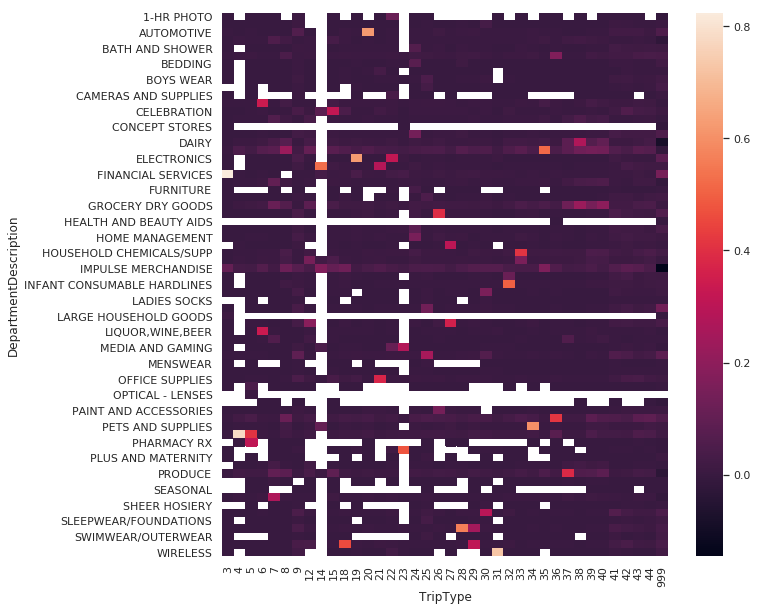

In [102]:
plt.figure(figsize=(10,10))
sns.heatmap(df_check_ratio.reset_index().pivot(index='DepartmentDescription', columns='TripType', values='TT_Dept_ratio'))
plt.show()

In [110]:
df['TripType'].nunique()

38

In [112]:
criteria = df_check_ratio.reset_index()['TT_Dept_ratio'] > 0.2
df_check_ratio.reset_index()[criteria].nunique()

TripType                 28
DepartmentDescription    29
ratio_sum                35
TT_Dept_ratio            35
dtype: int64

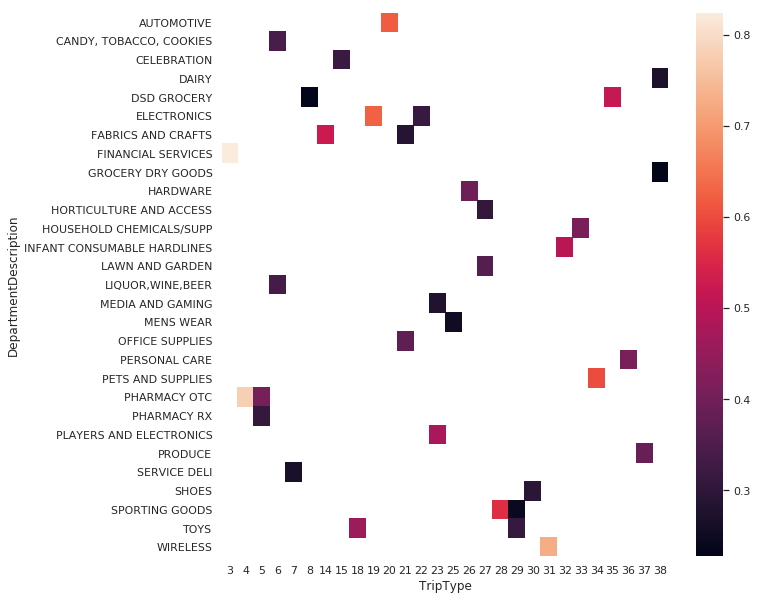

In [108]:
criteria = df_check_ratio['TT_Dept_ratio'] > 0.2
plt.figure(figsize=(10,10))
sns.heatmap(df_check_ratio[criteria].reset_index().pivot(index='DepartmentDescription', columns='TripType', values='TT_Dept_ratio'))
plt.show()

Top5

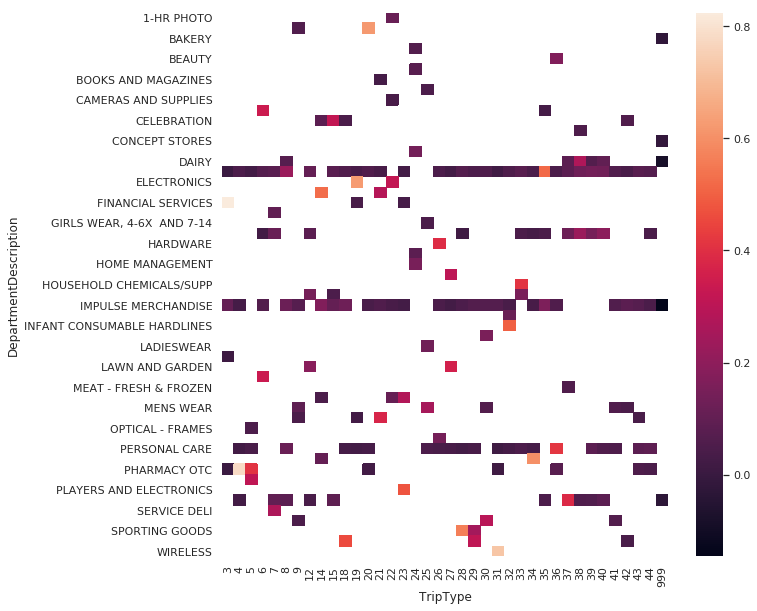

In [77]:
plt.figure(figsize=(10,10))
sns.heatmap(df_check_ratio.groupby('TripType').head(5).reset_index().pivot(index='DepartmentDescription', columns='TripType', values='TT_Dept_ratio'))
plt.show()

top5 Dept
- TT 별 점유율 top5

In [178]:
top5_Dept = list(df_check_ratio.groupby('TripType').head(5).reset_index()['DepartmentDescription'].drop_duplicates())

---

# test2
- new_col
    - isZeroNegative: Dept별 ScanSum이 0 또는 negative
        - 반품이 더 많거나 반품해서 실직적으로 구매한 것이 없음
    - IsPharmacy
        - Pharmacy별 FN교체

ZeorNegativeID

In [144]:
# VisitID of 'ScanCount Sum <= 0'
# new_col: IsZeroNegative
idx = np.where(df_d_sum.groupby('VisitNumber')['ScanCount'].transform(sum) <= 0)[0]
df_d_sum.loc[idx, 'VisitNumber'].nunique()

6198

Pharmacy FN

In [176]:
criteria = df['DepartmentDescription'].str.contains('PHARM', na=False)
# df[criteria][['VisitNumber', 'DepartmentDescription', 'FinelineNumber']].nunique()
Ph_FN = list(df[criteria]['FinelineNumber'].unique())

In [120]:
# Test
df_ratio

DepartmentDescription     ratio
VisitNumber TripType                                       
106.0       3                  FINANCIAL SERVICES  1.000000
121.0       3                  FINANCIAL SERVICES  1.000000
153.0       3                  FINANCIAL SERVICES  1.000000
162.0       3                  FINANCIAL SERVICES  1.000000
164.0       3                  FINANCIAL SERVICES  1.000000
177.0       3                  FINANCIAL SERVICES  0.500000
            3                 IMPULSE MERCHANDISE  0.500000
181.0       3                  FINANCIAL SERVICES  1.000000
188.0       3                  FINANCIAL SERVICES  1.000000
203.0       3                  FINANCIAL SERVICES  1.000000
265.0       3                  FINANCIAL SERVICES  0.500000
            3                 IMPULSE MERCHANDISE  0.500000
290.0       3                  FINANCIAL SERVICES  1.000000
322.0       3                  FINANCIAL SERVICES  1.000000
328.0       3                  FINANCIAL SERVICES  1.000000
348.0       3                  FINANCIAL SERVICES  1.000000
359.0       3                  FINANCIAL SERVICES  1.000000
369.0       3                  FINANCIAL SERVICES  1.000000
383.0       3                  FINANCIAL SERVICES  1.000000
399.0       3                  FINANCIAL SERVICES  1.000000
412.0       3                  FINANCIAL SERVICES  1.000000
425.0       3                  FINANCIAL SERVICES  1.000000
456.0       3                  FINANCIAL SERVICES  0.500000
            3                 IMPULSE MERCHANDISE  0.500000
465.0       3                  FINANCIAL SERVICES  1.000000
497.0       3                  FINANCIAL SERVICES  1.000000
503.0       3                  FINANCIAL SERVICES  1.000000
524.0       3                  FINANCIAL SERVICES  1.000000
578.0       3                  FINANCIAL SERVICES  1.000000
615.0       3                  FINANCIAL SERVICES  1.000000
621.0       3                  FINANCIAL SERVICES  1.000000
639.0       3                  FINANCIAL SERVICES  1.000000
651.0       3                  FINANCIAL SERVICES  1.000000
664.0       3                  FINANCIAL SERVICES  1.000000
700.0       3                  FINANCIAL SERVICES  1.000000
717.0       3                  FINANCIAL SERVICES  1.000000
728.0       3                  FINANCIAL SERVICES  1.000000
743.0       3                  FINANCIAL SERVICES  1.000000
775.0       3                  FINANCIAL SERVICES  1.000000
804.0       3                  FINANCIAL SERVICES  1.000000
814.0       3                  FINANCIAL SERVICES  1.000000
818.0       3                 IMPULSE MERCHANDISE  1.000000
838.0       3                  FINANCIAL SERVICES  1.000000
841.0       3                  FINANCIAL SERVICES  1.000000
858.0       3                  FINANCIAL SERVICES  1.000000
861.0       3                  FINANCIAL SERVICES  1.000000
888.0       3                  FINANCIAL SERVICES  1.000000
942.0       3                  FINANCIAL SERVICES  1.000000
944.0       3                  FINANCIAL SERVICES  0.500000
            3                 IMPULSE MERCHANDISE  0.500000
...                                           ...       ...
190182.0    999                      SERVICE DELI  0.500000
            999                                Na -0.500000
190272.0    999                        LADIESWEAR -1.000000
190284.0    999                   HOME MANAGEMENT  0.000000
            999                          MENSWEAR  0.000000
190292.0    999               IMPULSE MERCHANDISE  0.166667
            999                          HARDWARE -0.833333
190296.0    999                 GROCERY DRY GOODS  0.000000
190308.0    999                      PHARMACY OTC  1.000000
            999                         MENS WEAR  0.000000
190357.0    999                        COMM BREAD  0.000000
190360.0    999                       DSD GROCERY  0.333333
            999                   HOME MANAGEMENT  0.333333
            999               IMPULSE MERCHANDISE  0.333333
190391.0

## Filter by top5 Dept
- filter실패: 
    - 배제된 VisitID 912개
        - 구분해야 하는 Boolean Dept 13개
    - TT 5, 7, 9, 24, 25, 30, 999

In [187]:
c = df_ratio['DepartmentDescription'].isin(top5_Dept)
diff = set(df['VisitNumber'].unique()) - set(df_ratio[c].reset_index()['VisitNumber'].unique())

In [197]:
len(diff)

912

In [195]:
c = df_ratio.reset_index()['VisitNumber'].isin(diff)
display_all_rows(df_ratio.reset_index()[c])

,VisitNumber,TripType,DepartmentDescription,ratio
5284,1280.0,5,OPTICAL - LENSES,1.000000
5384,3103.0,5,OPTICAL - LENSES,1.000000
5640,8512.0,5,OPTICAL - LENSES,1.000000
6755,33294.0,5,OPTICAL - LENSES,1.000000
7028,38388.0,5,OPTICAL - LENSES,1.000000
7066,38775.0,5,OPTICAL - LENSES,1.000000
7173,40913.0,5,OPTICAL - LENSES,1.000000
7329,44536.0,5,OPTICAL - LENSES,1.000000
7375,45177.0,5,OPTICAL - LENSES,1.000000
7692,52704.0,5,OPTICAL - LENSES,1.000000


In [224]:
c2 = df_ratio.reset_index()['TripType'] != 999
df_ratio.reset_index()[c&c2].groupby(['TripType','DepartmentDescription'])['DepartmentDescription'].count().rename('count')

TripType  DepartmentDescription
30        SHEER HOSIERY             2
          ACCESSORIES               2
25        Na                        2
          SHEER HOSIERY             4
          ACCESSORIES               4
          MENSWEAR                  4
8         PRE PACKED DELI           5
25        LADIES SOCKS              8
          PLUS AND MATERNITY        8
9         PLUS AND MATERNITY        9
          Na                       10
25        SWIMWEAR/OUTERWEAR       12
9         FURNITURE                14
          SHEER HOSIERY            15
7         SEAFOOD                  17
9         LADIES SOCKS             20
25        SLEEPWEAR/FOUNDATIONS    20
          BRAS & SHAPEWEAR         23
9         SWIMWEAR/OUTERWEAR       25
          MENSWEAR                 27
5         OPTICAL - LENSES         28
7         PRE PACKED DELI          32
24        FURNITURE                43
9         SLEEPWEAR/FOUNDATIONS    58
          BRAS & SHAPEWEAR         59
          ACCESSOR

## Train Datset
- Dept top5 ratio sum
    - if all zero, then boolean
- negative sum booleman

Boolean filterling

top_dept5 + append +boolean Visit number

In [233]:
boolean_dept = list(df_ratio.reset_index().loc[c&c2, 'DepartmentDescription'].unique())
len(boolean_dept)
# boolean_dept

13

In [6]:
c = df_ratio['DepartmentDescription'].isin(top5_Dept)


DepartmentDescription     ratio
VisitNumber TripType                                       
106.0       3                  FINANCIAL SERVICES  1.000000
121.0       3                  FINANCIAL SERVICES  1.000000
153.0       3                  FINANCIAL SERVICES  1.000000
162.0       3                  FINANCIAL SERVICES  1.000000
164.0       3                  FINANCIAL SERVICES  1.000000
177.0       3                  FINANCIAL SERVICES  0.500000
            3                 IMPULSE MERCHANDISE  0.500000
181.0       3                  FINANCIAL SERVICES  1.000000
188.0       3                  FINANCIAL SERVICES  1.000000
203.0       3                  FINANCIAL SERVICES  1.000000
265.0       3                  FINANCIAL SERVICES  0.500000
            3                 IMPULSE MERCHANDISE  0.500000
290.0       3                  FINANCIAL SERVICES  1.000000
322.0       3                  FINANCIAL SERVICES  1.000000
328.0       3                  FINANCIAL SERVICES  1.000000
348.0       3                  FINANCIAL SERVICES  1.000000
359.0       3                  FINANCIAL SERVICES  1.000000
369.0       3                  FINANCIAL SERVICES  1.000000
383.0       3                  FINANCIAL SERVICES  1.000000
399.0       3                  FINANCIAL SERVICES  1.000000
412.0       3                  FINANCIAL SERVICES  1.000000
425.0       3                  FINANCIAL SERVICES  1.000000
456.0       3                  FINANCIAL SERVICES  0.500000
            3                 IMPULSE MERCHANDISE  0.500000
465.0       3                  FINANCIAL SERVICES  1.000000
497.0       3                  FINANCIAL SERVICES  1.000000
503.0       3                  FINANCIAL SERVICES  1.000000
524.0       3                  FINANCIAL SERVICES  1.000000
578.0       3                  FINANCIAL SERVICES  1.000000
615.0       3                  FINANCIAL SERVICES  1.000000
...                                           ...       ...
190403.0    999               IMPULSE MERCHANDISE  0.500000
            999                        HOME DECOR -0.500000
190410.0    999       INFANT CONSUMABLE HARDLINES -1.000000
190435.0    999                             SHOES  0.000000
190456.0    999                   HOME MANAGEMENT  1.000000
190473.0    999                        COMM BREAD  0.500000
            999                           PRODUCE  0.500000
190485.0    999               IMPULSE MERCHANDISE  0.333333
190502.0    999                   HOME MANAGEMENT -0.333333
            999                   OFFICE SUPPLIES -0.333333
            999                             SHOES -0.333333
190571.0    999                           PRODUCE  0.000000
190582.0    999                  MEDIA AND GAMING  1.000000
190624.0    999                              TOYS -1.000000
190641.0    999           HORTICULTURE AND ACCESS  0.500000
            999                       DSD GROCERY  0.166667
            999                FABRICS AND CRAFTS  0.166667
            999                      PHARMACY OTC  0.166667
190643.0    999                FINANCIAL SERVICES -1.000000
190736.0    999               IMPULSE MERCHANDISE  0.500000
            999                          HARDWARE -0.500000
190790.0    999               IMPULSE MERCHANDISE -1.000000
190792.0    999                             DAIRY  0.666667
            999               BOOKS AND MAGAZINES  0.333333
190805.0    999                   HOME MANAGEMENT  1.000000
190843.0    999                          HARDWARE -1.000000
190888.0    999                           PRODUCE  0.000000
190930.0    999                     PERSONAL CARE -1.000000
191161.0    999           CANDY, TOBACCO, COOKIES  0.500000
            999                       ELECTRONICS  0.500000

[307243 rows x 2 columns]

In [ ]:
le.fit_transform

[1]	training's multi_logloss: 2.9451	valid_1's multi_logloss: 2.95208
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 2.85142	valid_1's multi_logloss: 2.86463
[3]	training's multi_logloss: 2.7749	valid_1's multi_logloss: 2.79159
[4]	training's multi_logloss: 2.70354	valid_1's multi_logloss: 2.72565
[5]	training's multi_logloss: 2.64424	valid_1's multi_logloss: 2.66976
[6]	training's multi_logloss: 2.58584	valid_1's multi_logloss: 2.61558
[7]	training's multi_logloss: 2.53454	valid_1's multi_logloss: 2.56707
[8]	training's multi_logloss: 2.48682	valid_1's multi_logloss: 2.52188
[9]	training's multi_logloss: 2.44239	valid_1's multi_logloss: 2.47979
[10]	training's multi_logloss: 2.40075	valid_1's multi_logloss: 2.44039
[11]	training's multi_logloss: 2.36169	valid_1's multi_logloss: 2.40328
[12]	training's multi_logloss: 2.32481	valid_1's multi_logloss: 2.36831
[13]	training's multi_logloss: 2.28964	valid_1's multi_logloss: 2.33498
[14]	training

[115]	training's multi_logloss: 1.16532	valid_1's multi_logloss: 1.28852
[116]	training's multi_logloss: 1.16153	valid_1's multi_logloss: 1.28528
[117]	training's multi_logloss: 1.15779	valid_1's multi_logloss: 1.28207
[118]	training's multi_logloss: 1.15415	valid_1's multi_logloss: 1.27895
[119]	training's multi_logloss: 1.15054	valid_1's multi_logloss: 1.27586
[120]	training's multi_logloss: 1.14692	valid_1's multi_logloss: 1.27281
[121]	training's multi_logloss: 1.14332	valid_1's multi_logloss: 1.26968
[122]	training's multi_logloss: 1.13985	valid_1's multi_logloss: 1.26674
[123]	training's multi_logloss: 1.13635	valid_1's multi_logloss: 1.26378
[124]	training's multi_logloss: 1.13288	valid_1's multi_logloss: 1.26086
[125]	training's multi_logloss: 1.12947	valid_1's multi_logloss: 1.258
[126]	training's multi_logloss: 1.12614	valid_1's multi_logloss: 1.25519
[127]	training's multi_logloss: 1.12285	valid_1's multi_logloss: 1.25236
[128]	training's multi_logloss: 1.11963	valid_1's mul

[227]	training's multi_logloss: 0.924716	valid_1's multi_logloss: 1.09927
[228]	training's multi_logloss: 0.923517	valid_1's multi_logloss: 1.09846
[229]	training's multi_logloss: 0.92231	valid_1's multi_logloss: 1.09769
[230]	training's multi_logloss: 0.921095	valid_1's multi_logloss: 1.0969
[231]	training's multi_logloss: 0.919891	valid_1's multi_logloss: 1.09611
[232]	training's multi_logloss: 0.918706	valid_1's multi_logloss: 1.09535
[233]	training's multi_logloss: 0.917522	valid_1's multi_logloss: 1.09462
[234]	training's multi_logloss: 0.916372	valid_1's multi_logloss: 1.0939
[235]	training's multi_logloss: 0.915209	valid_1's multi_logloss: 1.09318
[236]	training's multi_logloss: 0.914055	valid_1's multi_logloss: 1.09243
[237]	training's multi_logloss: 0.912916	valid_1's multi_logloss: 1.09172
[238]	training's multi_logloss: 0.91177	valid_1's multi_logloss: 1.091
[239]	training's multi_logloss: 0.910657	valid_1's multi_logloss: 1.09033
[240]	training's multi_logloss: 0.909526	val

[339]	training's multi_logloss: 0.825794	valid_1's multi_logloss: 1.04594
[340]	training's multi_logloss: 0.825121	valid_1's multi_logloss: 1.04563
[341]	training's multi_logloss: 0.824472	valid_1's multi_logloss: 1.04539
[342]	training's multi_logloss: 0.823817	valid_1's multi_logloss: 1.04511
[343]	training's multi_logloss: 0.823126	valid_1's multi_logloss: 1.04483
[344]	training's multi_logloss: 0.822474	valid_1's multi_logloss: 1.04454
[345]	training's multi_logloss: 0.821826	valid_1's multi_logloss: 1.04429
[346]	training's multi_logloss: 0.821173	valid_1's multi_logloss: 1.04402
[347]	training's multi_logloss: 0.82054	valid_1's multi_logloss: 1.04375
[348]	training's multi_logloss: 0.819908	valid_1's multi_logloss: 1.0435
[349]	training's multi_logloss: 0.819281	valid_1's multi_logloss: 1.04324
[350]	training's multi_logloss: 0.818572	valid_1's multi_logloss: 1.043
[351]	training's multi_logloss: 0.817947	valid_1's multi_logloss: 1.04278
[352]	training's multi_logloss: 0.81733	va

[451]	training's multi_logloss: 0.765085	valid_1's multi_logloss: 1.02599
[452]	training's multi_logloss: 0.764636	valid_1's multi_logloss: 1.0259
[453]	training's multi_logloss: 0.764181	valid_1's multi_logloss: 1.02581
[454]	training's multi_logloss: 0.763753	valid_1's multi_logloss: 1.02568
[455]	training's multi_logloss: 0.763314	valid_1's multi_logloss: 1.02558
[456]	training's multi_logloss: 0.762891	valid_1's multi_logloss: 1.02549
[457]	training's multi_logloss: 0.762456	valid_1's multi_logloss: 1.02539
[458]	training's multi_logloss: 0.762021	valid_1's multi_logloss: 1.0253
[459]	training's multi_logloss: 0.76159	valid_1's multi_logloss: 1.02519
[460]	training's multi_logloss: 0.761163	valid_1's multi_logloss: 1.02511
[461]	training's multi_logloss: 0.760743	valid_1's multi_logloss: 1.02502
[462]	training's multi_logloss: 0.76031	valid_1's multi_logloss: 1.02492
[463]	training's multi_logloss: 0.759878	valid_1's multi_logloss: 1.02484
[464]	training's multi_logloss: 0.759463	v

[563]	training's multi_logloss: 0.722772	valid_1's multi_logloss: 1.01904
[564]	training's multi_logloss: 0.722456	valid_1's multi_logloss: 1.01901
[565]	training's multi_logloss: 0.722137	valid_1's multi_logloss: 1.01897
[566]	training's multi_logloss: 0.721806	valid_1's multi_logloss: 1.01896
[567]	training's multi_logloss: 0.721502	valid_1's multi_logloss: 1.01891
[568]	training's multi_logloss: 0.721184	valid_1's multi_logloss: 1.01888
[569]	training's multi_logloss: 0.720858	valid_1's multi_logloss: 1.01885
[570]	training's multi_logloss: 0.720535	valid_1's multi_logloss: 1.01883
[571]	training's multi_logloss: 0.720213	valid_1's multi_logloss: 1.0188
[572]	training's multi_logloss: 0.719895	valid_1's multi_logloss: 1.01879
[573]	training's multi_logloss: 0.719582	valid_1's multi_logloss: 1.01875
[574]	training's multi_logloss: 0.71927	valid_1's multi_logloss: 1.01873
[575]	training's multi_logloss: 0.718953	valid_1's multi_logloss: 1.01869
[576]	training's multi_logloss: 0.718634

In [ ]:
print(classification_report(y_labeled, lightgbm_model.predict(X)))

In [388]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y = df_train.iloc[:, -1]
x = df_train.drop('TripType', axis=1)

X_t, X_te, y_t, y_te = train_test_split(x, y, test_size = 0.2, random_state=99,\
                                       stratify=y)

mod = RandomForestClassifier(n_estimators=200, bootstrap=False, min_samples_leaf=1, min_samples_split=3,\
                             criterion='gini').fit(X_t, y_t)

print(classification_report(y_te, mod2.predict(X_te)))

# make pickle file

In [12]:
from sklearn import tree
with open("DeptTree.dot", 'w') as f:
    f = tree.export_graphviz(mod, out_file=f)

In [57]:
# ls = df_ratio['TripType'].unique()
# i = 0

# for row in range(19):
#     for col in range(2):
#         criteria = df_ratio['TripType'] == ls[i]
#         data = df_ratio[criteria].iloc[:, [2, -1, 0, -2]]
#         plot = sns.barplot(x='DepartmentDescription', y='ratio', hue='VisitNumber', data=data, ax=axes[row][col])
#         plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
#         plot.set_title('{}type'.format(i))
#         i += 1
# plt.show()        

# ScanCount 재정리
- Dept 무시
- FN & Upc로 FN ScanCount Sum
    - Sum > 0 -> Value count로 Sum
    - Sum = 0 -> informative 0 -> FN ratio:0
    - Sum < 0 -> 

In [3]:
df_sum = df.groupby(['VisitNumber', 'FinelineNumber', 'Upc'], as_index=False)['ScanCount'].agg('sum').rename(columns={'ScanCount': 'SCSum'})
df_sum[:5]

,VisitNumber,FinelineNumber,Upc,SCSum
0,5,1000.0,6.811315e+10,-1
1,7,4504.0,7.410811e+09,1
2,7,8931.0,6.053882e+10,1
3,8,7.0,2.236760e+09,1
4,8,707.0,7.874205e+09,1


# create abs_sum

In [4]:
import numba
from numba import njit

In [18]:
df_sum['SCSum_abs'] = df_sum['SCSum'].apply(np.abs)
df_sum = pd.merge(df_sum, df_sum.groupby(['VisitNumber', 'FinelineNumber'], as_index=False)['SCSum_abs'].sum().rename(columns={'SCSum_abs':'FN_SCSum_abs'}), on=['VisitNumber', 'FinelineNumber'])

In [20]:
df_sum[:100]

,VisitNumber,FinelineNumber,Upc,SCSum,SCSum_abs,FN_SCSum_abs
0,5,1000.0,6.811315e+10,-1,1,1
1,7,4504.0,7.410811e+09,1,1,1
2,7,8931.0,6.053882e+10,1,1,1
3,8,7.0,2.236760e+09,1,1,1
4,8,707.0,7.874205e+09,1,1,1
5,8,1001.0,3.270011e+09,3,3,3
6,8,1017.0,2.006614e+09,1,1,5
7,8,1017.0,2.006614e+09,2,2,5
8,8,1017.0,2.006619e+09,2,2,5
9,8,1018.0,7.245040e+10,2,2,2


# ratio
- SCSum = 0 -> FNratio = 0
- the Rest -> FNratio = SCSum / abs_SCSum

In [24]:
idx = np.where(df_sum['SCSum'] == 0)[0]
df_sum.loc[idx, 'ratio'] = 0
idx = np.where(df_sum['SCSum'] != 0)[0]
df_sum.loc[idx, 'ratio'] = df_sum.loc[idx, 'SCSum'] /df_sum.loc[idx, 'FN_SCSum_abs']
df_sum.sort_values(['VisitNumber', 'FinelineNumber', 'ratio'], ascending=[1, 1, 0], inplace=True)

# Search for Visit ID whose all the FNratio = 0
- UPC NaN
- TT
    - 999
    - 8(1): cannnot tell reason
    - 5(1): Pharmacy

In [97]:
df[df['VisitNumber'].isin(m[m==True].index)].nunique()

TripType                    3
VisitNumber              1093
Weekday                     7
Upc                      1292
ScanCount                   9
DepartmentDescription      61
FinelineNumber            886
dtype: int64

In [74]:
def isall(s):
    return any(s)

g = df_sum.groupby(['VisitNumber'])
m = g['ratio'].agg(isall) == False

In [94]:
criteria = df['TripType'] != 999
df[criteria & df['VisitNumber'].isin(m[m==True].index)]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
321206,8,96445,Saturday,9.506000e+03,1,DSD GROCERY,9225.0
321207,8,96445,Saturday,9.506000e+03,-1,DSD GROCERY,9225.0
609297,5,181640,Saturday,NaN,1,PHARMACY RX,NaN
609298,5,181640,Saturday,6.951191e+10,1,FROZEN FOODS,6504.0
609299,5,181640,Saturday,6.951191e+10,-1,FROZEN FOODS,6504.0
609300,5,181640,Saturday,2.898998e+09,2,FROZEN FOODS,4122.0
609301,5,181640,Saturday,2.898998e+09,-2,FROZEN FOODS,4122.0


# problem
- Dept Pharmacy rx has no Upc & FN num(assign 0.1)

# solution
- add isPhar col
- add isNa col

In [110]:
phID = list(set(df['VisitNumber'].unique())-set(df_sum['VisitNumber'].unique()))

In [123]:
# isPh
idx = np.where(df['VisitNumber'].isin(phID))[0]
df['isPh'] = False
df.loc[idx, 'isPh'] = True 

# isNa
idx = np.where(df['DepartmentDescription'].isnull())[0]
df['isNa'] = False
df.loc[idx, 'isNa'] = True

# Complete df_sum
- upc ratio, FN ratio

In [177]:
df_upc = df_sum.loc[:, ['VisitNumber', 'FinelineNumber', 'Upc', 'ratio']]
df_upc[:5]

,VisitNumber,FinelineNumber,Upc,ratio
0,5,1000.0,6.811315e+10,-1.0
1,7,4504.0,7.410811e+09,1.0
2,7,8931.0,6.053882e+10,1.0
3,8,7.0,2.236760e+09,1.0
4,8,707.0,7.874205e+09,1.0


add missing visit Id with 'isNa' & 'isPh' col

In [137]:
any(df_sum['VisitNumber'].isin(phID))

False

In [178]:
df_upc['isPh'] = False
df_upc['isNa'] = False

In [191]:
# df_sub: VisitID which has no Upc&FN or Dept
df_sub = pd.DataFrame({'VisitNumber': phID,
                       'FinelineNumber': 0.1,
                       'Upc': 0,
                       'ratio': 0})

df_sub = pd.merge(df_sub, df[['VisitNumber', 'isPh', 'isNa']], on='VisitNumber')

# append
df_upc = df_upc.append(df_sub)
df_upc = df_upc.iloc[:, [2, 0, 1, 5, 3, 4]]
df_upc[:10]

,VisitNumber,FinelineNumber,Upc,ratio,isNa,isPh
0,5.0,1000.0,6.811315e+10,-1.0,False,False
1,7.0,4504.0,7.410811e+09,1.0,False,False
2,7.0,8931.0,6.053882e+10,1.0,False,False
3,8.0,7.0,2.236760e+09,1.0,False,False
4,8.0,707.0,7.874205e+09,1.0,False,False
5,8.0,1001.0,3.270011e+09,1.0,False,False
7,8.0,1017.0,2.006614e+09,0.4,False,False
8,8.0,1017.0,2.006619e+09,0.4,False,False
6,8.0,1017.0,2.006614e+09,0.2,False,False
9,8.0,1018.0,7.245040e+10,1.0,False,False


In [209]:
df_upc = pd.merge(df_upc, df_upc.groupby(['VisitNumber', 'FinelineNumber'], as_index=False)['Upc'].agg('count').rename(columns={'Upc':'FN_count'}), on=['VisitNumber', 'FinelineNumber'])
df_upc[:5]

,VisitNumber,FinelineNumber,Upc,ratio,isNa,isPh,FN_count
0,5.0,1000.0,6.811315e+10,-1.0,False,False,1
1,7.0,4504.0,7.410811e+09,1.0,False,False,1
2,7.0,8931.0,6.053882e+10,1.0,False,False,1
3,8.0,7.0,2.236760e+09,1.0,False,False,1
4,8.0,707.0,7.874205e+09,1.0,False,False,1


In [213]:
# FN most and Upc top3
df_upc = df_upc.assign(abs_ratio = df_upc['ratio'].abs()).sort_values(['VisitNumber', 'FN_count', 'abs_ratio'], ascending=[1, 0, 0]).drop('abs_ratio', axis=1).reset_index(drop=True)
df_upc[:5]

,VisitNumber,FinelineNumber,Upc,ratio,isNa,isPh,FN_count
0,5.0,1000.0,6.811315e+10,-1.0,False,False,1
1,7.0,4504.0,7.410811e+09,1.0,False,False,1
2,7.0,8931.0,6.053882e+10,1.0,False,False,1
3,8.0,1017.0,2.006614e+09,0.4,False,False,3
4,8.0,1017.0,2.006619e+09,0.4,False,False,3


add FN_ratio

In [223]:
df_FN = pd.merge(df_upc.iloc[:, [0, 1, -1]].drop_duplicates(),\
         df_upc.iloc[:, [0, 1, -1]].drop_duplicates().groupby(['VisitNumber'],as_index=False)['FN_count'].sum().rename(columns={'FN_count':'FN_sum'}),\
         on='VisitNumber')
df_FN.nunique()

VisitNumber       95674
FinelineNumber     5196
FN_count             26
FN_sum               99
dtype: int64

In [233]:
df_FN['FN_ratio'] = df_FN['FN_count'] / df_FN['FN_sum']
df_FN = df_FN.sort_values(['VisitNumber', 'FN_ratio', 'FinelineNumber'], ascending=[1, 0, 1])
df_FN

,VisitNumber,FinelineNumber,FN_count,FN_sum,FN_ratio
0,5.0,1000.0,1,1,1.000000
1,7.0,4504.0,1,2,0.500000
2,7.0,8931.0,1,2,0.500000
3,8.0,1017.0,3,20,0.150000
4,8.0,3565.0,2,20,0.100000
5,8.0,4415.0,2,20,0.100000
6,8.0,7.0,1,20,0.050000
7,8.0,707.0,1,20,0.050000
8,8.0,1001.0,1,20,0.050000
9,8.0,1018.0,1,20,0.050000


add Dept ratio

In [254]:
df_dept = pd.merge(df_upc, df[['VisitNumber', 'Upc', 'DepartmentDescription']].drop_duplicates(), on=['VisitNumber', 'Upc'])
df_dept[:5]

,VisitNumber,FinelineNumber,Upc,ratio,isNa,isPh,FN_count,DepartmentDescription
0,5.0,1000.0,6.811315e+10,-1.0,False,False,1,FINANCIAL SERVICES
1,7.0,4504.0,7.410811e+09,1.0,False,False,1,PERSONAL CARE
2,7.0,8931.0,6.053882e+10,1.0,False,False,1,SHOES
3,8.0,1017.0,2.006614e+09,0.4,False,False,3,PAINT AND ACCESSORIES
4,8.0,1017.0,2.006619e+09,0.4,False,False,3,PAINT AND ACCESSORIES


In [270]:
df_d_sub = df_dept.assign(c = 1).\
groupby(['VisitNumber', 'DepartmentDescription'], as_index=False)['c'].sum().rename(columns={'c':'D_sum'})
df_d_sub

,VisitNumber,DepartmentDescription,D_sum
0,5.0,FINANCIAL SERVICES,1
1,7.0,PERSONAL CARE,1
2,7.0,SHOES,1
3,8.0,DAIRY,1
4,8.0,DSD GROCERY,1
5,8.0,HOUSEHOLD CHEMICALS/SUPP,1
6,8.0,MEAT - FRESH & FROZEN,1
7,8.0,PAINT AND ACCESSORIES,14
8,8.0,PETS AND SUPPLIES,2
9,9.0,IMPULSE MERCHANDISE,1


In [291]:
pd.merge(df_d_sub, df_dept.groupby(['VisitNumber'], as_index=False)['DepartmentDescription'].count().rename(columns={'DepartmentDescription':'Dept_ttl'}),\
        on=['VisitNumber'])

,VisitNumber,DepartmentDescription,D_sum,Dept_ttl
0,5.0,FINANCIAL SERVICES,1,1
1,7.0,PERSONAL CARE,1,2
2,7.0,SHOES,1,2
3,8.0,DAIRY,1,20
4,8.0,DSD GROCERY,1,20
5,8.0,HOUSEHOLD CHEMICALS/SUPP,1,20
6,8.0,MEAT - FRESH & FROZEN,1,20
7,8.0,PAINT AND ACCESSORIES,14,20
8,8.0,PETS AND SUPPLIES,2,20
9,9.0,IMPULSE MERCHANDISE,1,3


In [230]:
df_c.iloc[:, [0, 1, -1, 2, 3, 4, 5]]

,VisitNumber,FinelineNumber,FN_ratio,Upc,ratio,isNa,isPh
0,5.0,1000.0,1.000000,6.811315e+10,-1.000000,False,False
1,7.0,4504.0,0.500000,7.410811e+09,1.000000,False,False
2,7.0,8931.0,0.500000,6.053882e+10,1.000000,False,False
3,8.0,1017.0,0.150000,2.006614e+09,0.400000,False,False
4,8.0,1017.0,0.150000,2.006619e+09,0.400000,False,False
5,8.0,1017.0,0.150000,2.006614e+09,0.200000,False,False
6,8.0,3565.0,0.100000,2.238404e+09,0.666667,False,False
7,8.0,3565.0,0.100000,2.238400e+09,0.333333,False,False
8,8.0,4415.0,0.100000,5.114139e+09,0.500000,False,False
9,8.0,4415.0,0.100000,5.114198e+09,0.500000,False,False


In [14]:
df_sum.sort_values(['VisitNumber', 'FinelineNumber', 'SCSum'], ascending=[1, 1, 0], inplace=True)

In [22]:
df_fn_sum = pd.merge(df_sum, df_sum.groupby(['VisitNumber', 'FinelineNumber'], as_index=False)['SCSum'].agg('sum').rename(columns={'SCSum':'FN_SCSum'}), on=['VisitNumber', 'FinelineNumber'])
df_fn_sum[:5]

,VisitNumber,FinelineNumber,Upc,SCSum,FN_SCSum
0,5,1000.0,6.811315e+10,-1,-1
1,7,4504.0,7.410811e+09,1,1
2,7,8931.0,6.053882e+10,1,1
3,8,7.0,2.236760e+09,1,1
4,8,707.0,7.874205e+09,1,1
